In [4]:
! pip install -U -q langgraph langchain-google-genai langchain_core

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict

# TypedDictState Class
class TypedDictState(TypedDict):
    foo:str
    bar:str


obj1 : TypedDictState = TypedDictState(foo="Hello",bar="World")
print(obj1)

{'foo': 'Hello', 'bar': 'World'}


In [61]:
from typing import Literal

class TypedDictState(TypedDict):
    name:str
    mood:Literal['happy','sad']

# Does not raise error even if you provide more or less keys or of different data types as defined in the class
obj2 :TypedDictState = TypedDictState(name=1,mood="mad",random_field="XYZ")
obj2

{'name': 1, 'mood': 'mad', 'random_field': 'XYZ'}

In [62]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from langgraph.graph.state import CompiledStateGraph
import random

def node_1(state:TypedDictState):
    print("Node 1")
    return {"name":state["name"]+ " is ...."}

def node_2(state:TypedDictState):
   print("node 2")
   return {'mood':'happy'}

def node_3(state:TypedDictState):
    print("node 3")
    return {"mood":"sad"}

def decide_mood(state:TypedDictState)-> Literal['node2','node3']:
    if random.random() > 0.5:
       return 'node2'
    return 'node3'

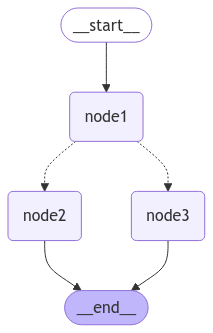

In [63]:

workflow:StateGraph = StateGraph(TypedDictState)

workflow.add_node('node1',node_1)
workflow.add_node('node2',node_2)
workflow.add_node('node3',node_3)

workflow.add_edge(START,'node1')
workflow.add_conditional_edges(
    'node1', decide_mood )
workflow.add_edge('node2',END)
workflow.add_edge('node3',END)

graph:CompiledStateGraph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
graph.invoke({'name':'Shahmir'})

Node 1
node 3


{'name': 'Shahmir is ....', 'mood': 'sad'}

In [75]:
from dataclasses import dataclass

@dataclass
class DataClassState:
    name:str
    mood:Literal['happy','sad']


def node_1(state:DataClassState):
    print("node 1")
    return {'name':state.name}

def node_2(state:DataClassState):
    print('node 2')
    return {'mood':'happy'}

def node_3(state:DataClassState):
    print('node 3')
    return {'mood':'sad'}

def decide_mood(state:DataClassState)->Literal['node2','node3']:
    if random.random() > 0.5:
        return 'node2'
    return 'node3'

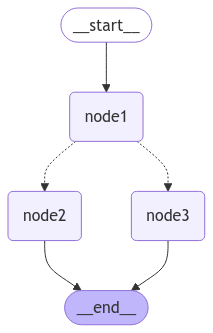

In [76]:
workflow : StateGraph = StateGraph(DataClassState)

workflow.add_node('node1',node_1)
workflow.add_node('node2',node_2)
workflow.add_node('node3',node_3)

workflow.set_entry_point('node1')
workflow.add_conditional_edges('node1',decide_mood)

workflow.add_edge('node2',END)
workflow.add_edge('node3',END)

graph : CompiledStateGraph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
# In dataclasses It will only give error if you missed any key of class
graph.invoke(DataClassState(name="Jack"))

TypeError: DataClassState.__init__() missing 1 required positional argument: 'mood'

In [80]:
# But it also not gives any error if you pass different data type from the one defined inside of the class
graph.invoke(DataClassState(name=1,mood='mad'))

node 1
node 2


{'name': 1, 'mood': 'happy'}

As mentioned, TypedDict and dataclasses provide type hints but they don't enforce types at runtime.

This means you could potentially assign invalid values without raising an error!

For example, we can set mood to mad even though our type hint specifies  `mood: list[Literal["happy","sad"]]`.

In [58]:
from pydantic import BaseModel,ValidationError

class PydanticState(BaseModel):
    name:str
    mood:Literal['happy','sad']

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/literal_error
